# テーマ：kickstarterが成功するか失敗するか分類したい

## １．データ項目の説明

初期状態について、ファンディング開始時に値が確定or未定を表示

項目名　| 意味 | 初期状態 | 目的変数
-----------| ------------ | ------- | -----
ID | kickstarterのID | 確定 | 
name| プロジェクト名称| 確定 | 
category | カテゴリ | 確定 | 
main_category | キャンペーンのカテゴリ | 確定 | 
currency | 通貨 | 確定 | 
deadline | クラウドファンディングの締め切り | 確定 | 
goal | 目標額（currency） | 確定 | 
launched | 発売日 | 確定 | 
pledged | 誓約額（currency） | 未定 | 
state | 現在のプロジェクト状態 | 未定 | 〇
backers | 支援者の数 | 未定 | 
country | 国名（誓約） | 未定 | 
usd pledged | 誓約額（USD換算（KS)） | 未定 | 
usd_pledged_real | 誓約額（USD換算（fixer.io api)） | 未定 | 
usd_goal_real | 目標額（USD換算（fixer.io api)） | 確定 | 


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
##CSVファイルを読み込みdataframeに変換
df_kick = pd.read_csv("./ks-projects-201801.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal','launched','pledged','state','backers','country','usd pledged','usd_pledged_real','usd_goal_real']]
#読み込み行数を制限して動作を確認する
df_kick = df_kick.sample(frac=0.01)

In [4]:

#〇目的変数はstateとして実施する
#目的変数を１，０に変換する、stateにはsuccessfulとfailed以外がある
#######successfulとfailed以外を除外した場合にどうなるか検討が必要
#df_kick['state'] = df_kick['state'] == 'successful'

#〇説明変数の中で区分などを変換する
#そのままではなく、相関関係や切り口を変えたものが結果に影響するものを新規列として追加する
#・クラウドファンディングの締め切りから発売日までの日数
#・プロジェクト名称の文字数
#・・・・・・？


#通貨の分類をダミー変数として追加、USD、GBP、その他に圧縮
#df_kick.loc[~(df_kick.currency == 'USD') & (~(df_kick.currency == 'GBP')), 'currency'] = 'other'
#カテゴリの分類をダミー変数として追加
df_kick_dummy=pd.get_dummies(df_kick.category)
df_kick = pd.concat([df_kick, df_kick_dummy], axis=1)
#キャンペーンのカテゴリの分類をダミー変数として追加
df_kick_dummy=pd.get_dummies(df_kick.main_category)
df_kick = pd.concat([df_kick, df_kick_dummy], axis=1)
#通貨の分類をダミー変数として追加
df_kick_dummy=pd.get_dummies(df_kick.currency)
df_kick = pd.concat([df_kick, df_kick_dummy], axis=1)

#deadlineからlaunchedを引いた日数を新しい列（term）を追加
def f_str(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')
df_kick.deadline = df_kick.deadline.map(f_str)
def f_str(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_kick.launched = df_kick.launched.map(f_str)
df_kick["term"] = df_kick.deadline-df_kick.launched
def f_str(x):
    if x.days > 10000:
        return 0
    else:
        return x.days
df_kick["term_day"] = df_kick.term.map(f_str)

#プロジェクト名称の文字数で新しい列（name_len）を追加
def f_str(x):
    if type(x) is str:
        return len(x)
    else:
        return 0
df_kick["name_len"] = df_kick.name.map(f_str)

display(df_kick.head())

df_kick.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,JPY,MXN,NOK,NZD,SEK,SGD,USD,term,term_day,name_len
309211,645028834,How Deep The Love,Music,Music,USD,2013-08-15,900.0,2013-07-09 16:11:50,70.0,failed,...,0,0,0,0,0,0,1,36 days 07:48:10,36,17
342791,81626406,Summer FourPlay,Plays,Theater,USD,2014-07-19,4000.0,2014-07-09 20:55:05,4040.0,successful,...,0,0,0,0,0,0,1,9 days 03:04:55,9,15
368823,949073709,FRUITY Photography With a Few VEGGIES Thrown In,Photography,Photography,USD,2013-04-09,400.0,2013-03-20 22:02:45,0.0,failed,...,0,0,0,0,0,0,1,19 days 01:57:15,19,47
333137,767050973,Tug-of-war Dog Toy that allows your dog to Pla...,Product Design,Design,USD,2017-03-29,5000.0,2017-02-27 14:00:26,267.0,failed,...,0,0,0,0,0,0,1,29 days 09:59:34,29,54
370268,95666028,The Birdhouse Builder,Woodworking,Crafts,USD,2014-10-12,5000.0,2014-09-12 19:40:58,100.0,failed,...,0,0,0,0,0,0,1,29 days 04:19:02,29,21


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,3D Printing,Academic,Accessories,...,JPY,MXN,NOK,NZD,SEK,SGD,USD,term,term_day,name_len
count,3.787000e+03,3.787000e+03,3.787000e+03,3787.000000,3.750000e+03,3.787000e+03,3.787000e+03,3787.000000,3787.000000,3787.000000,...,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787,3787.000000,3787.000000
mean,1.064892e+09,1.075282e+05,9.700539e+03,100.313705,6.753036e+03,9.231790e+03,9.835019e+04,0.001320,0.003169,0.009242,...,0.000264,0.003697,0.001056,0.005281,0.006073,0.001320,0.778189,33 days 16:58:16.889886,33.278321,34.765778
std,6.150980e+08,2.277661e+06,6.819362e+04,505.406395,4.517432e+04,6.644462e+04,2.032457e+06,0.036317,0.056210,0.095703,...,0.016250,0.060697,0.032487,0.072489,0.077705,0.036317,0.415520,12 days 15:22:46.502879,12.622779,16.000539
min,2.370900e+05,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1 days 18:33:18,1.000000,3.000000
25%,5.443378e+08,2.000000e+03,2.500000e+01,2.000000,1.256500e+01,2.500000e+01,2.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,29 days 02:32:41.500000,29.000000,21.000000
50%,1.060248e+09,5.500000e+03,6.070000e+02,12.000000,3.595000e+02,6.000000e+02,5.500000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,29 days 16:38:28,29.000000,34.000000
75%,1.586737e+09,1.768500e+04,3.858580e+03,56.000000,3.088030e+03,3.868570e+03,1.656839e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,36 days 05:36:26.500000,36.000000,48.000000
max,2.147431e+09,1.000000e+08,2.762572e+06,16936.000000,1.766205e+06,2.762572e+06,7.947862e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90 days 21:19:02,90.000000,95.000000


### 目標額、目標額（USD換算（fixer.io api)）を標準化

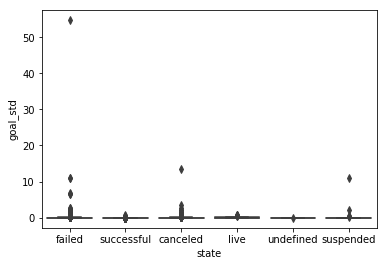

In [49]:
#目標額を標準化し新しい列goal_stdを追加
stdsc = StandardScaler()
df_kick["goal_std"] = stdsc.fit_transform(df_kick[["goal"]].values)
sns.boxplot(df_kick.state,df_kick.goal_std)
plt.show()

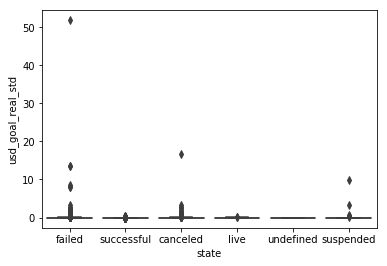

In [50]:
#目標額（USD換算（fixer.io api)）を標準化し新しい列goal_stdを追加
stdsc = StandardScaler()
df_kick["usd_goal_real_std"] = stdsc.fit_transform(df_kick[["usd_goal_real"]].values)
sns.boxplot(df_kick.state,df_kick.usd_goal_real_std)
plt.show()

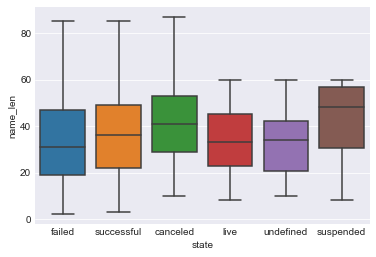

In [69]:
# 箱ひげ図を書いてみる 状況とプロジェクト名の文字数
sns.boxplot(df_kick.state,df_kick.name_len)
plt.show()

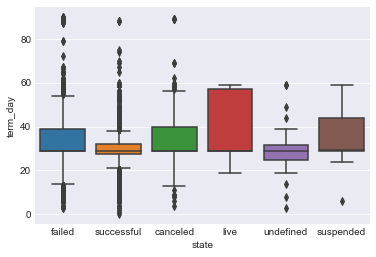

In [70]:
# 箱ひげ図を書いてみる 状況と期限日数
sns.boxplot(df_kick.state,df_kick.term_day)
plt.show()

In [67]:
#null値が入っている行を調査
df_kick.isnull().sum()/df_kick.shape[0]

ID                   0.000000
name                 0.000000
category             0.000000
main_category        0.000000
currency             0.000000
deadline             0.000000
goal                 0.000000
launched             0.000000
pledged              0.000000
state                0.000000
backers              0.000000
country              0.000000
usd pledged          0.008714
usd_pledged_real     0.000000
usd_goal_real        0.000000
3D Printing          0.000000
Academic             0.000000
Accessories          0.000000
Action               0.000000
Animals              0.000000
Animation            0.000000
Anthologies          0.000000
Apparel              0.000000
Apps                 0.000000
Architecture         0.000000
Art                  0.000000
Art Books            0.000000
Audio                0.000000
Bacon                0.000000
Blues                0.000000
                       ...   
Dance                0.000000
Design               0.000000
Fashion   

In [68]:
#null値が入っている行を確認（name列にnull値が入っている場合に真）
df_kick[(df_kick['name'].isnull())]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,NOK,NZD,SEK,SGD,USD,term,term_day,name_len,goal_std,usd_goal_real_std


## category,main_category,currency毎でsuccessfulの割合に違いがあるかを確認

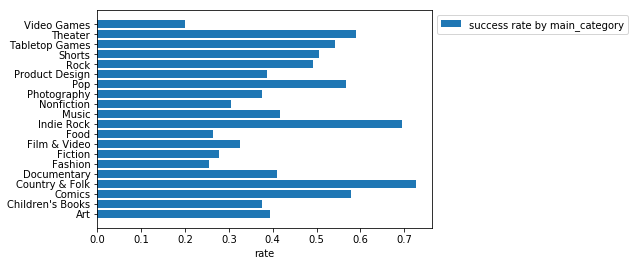

In [83]:
#category
suc_head20 = df_kick[df_kick.state=='successful'].category.value_counts().head(20)
y_suc = suc_head20.index
sfrate_x = np.array([])
sfrate_y = np.array([])
for indx in y_suc:
    count_success = df_kick[(df_kick.state=='successful')&(df_kick.category==indx)].category.value_counts()
    count_fail = df_kick[(df_kick.state!='successful')&(df_kick.category==indx)].category.value_counts()
    rate = float(count_success/(count_fail+count_success))
    sfrate_x = np.append(sfrate_x,[str(indx)],axis=0)
    sfrate_y = np.append(sfrate_y,[rate],axis=0)
#グラフの描画
label1 = 'success rate by main_category'
# 棒グラフの描画
plt.barh(sfrate_x, sfrate_y, label=label1)
# x軸，y軸のラベルを設定
plt.xlabel('rate')
# 凡例を表示
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
#main_category
suc_head20 = df_kick[df_kick.state=='successful'].main_category.value_counts().head(20)
y_suc = suc_head20.index
sfrate_x = np.array([])
sfrate_y = np.array([])
for indx in y_suc:
    count_success = df_kick[(df_kick.state=='successful')&(df_kick.main_category==indx)].main_category.value_counts()
    count_fail = df_kick[(df_kick.state!='successful')&(df_kick.main_category==indx)].main_category.value_counts()
    rate = float(count_success/(count_fail+count_success))
    sfrate_x = np.append(sfrate_x,[str(indx)],axis=0)
    sfrate_y = np.append(sfrate_y,[rate],axis=0)
#グラフの描画
label1 = 'success rate by main_category'
# 棒グラフの描画
plt.barh(sfrate_x, sfrate_y, label=label1)
# x軸，y軸のラベルを設定
plt.xlabel('rate')
# 凡例を表示
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

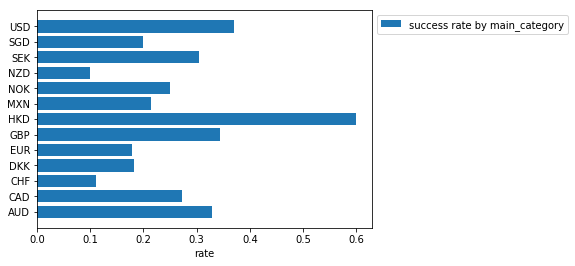

In [84]:
#currency
suc_head20 = df_kick[df_kick.state=='successful'].currency.value_counts().head(20)
y_suc = suc_head20.index
sfrate_x = np.array([])
sfrate_y = np.array([])
for indx in y_suc:
    count_success = df_kick[(df_kick.state=='successful')&(df_kick.currency==indx)].currency.value_counts()
    count_fail = df_kick[(df_kick.state!='successful')&(df_kick.currency==indx)].currency.value_counts()
    rate = float(count_success/(count_fail+count_success))
    sfrate_x = np.append(sfrate_x,[str(indx)],axis=0)
    sfrate_y = np.append(sfrate_y,[rate],axis=0)
#グラフの描画
label1 = 'success rate by main_category'
# 棒グラフの描画
plt.barh(sfrate_x, sfrate_y, label=label1)
# x軸，y軸のラベルを設定
plt.xlabel('rate')
# 凡例を表示
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [86]:
display(df_kick.head())
df_kick.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,JPY,MXN,NOK,NZD,SEK,SGD,USD,term,term_day,name_len
309211,645028834,How Deep The Love,Music,Music,USD,2013-08-15,900.0,2013-07-09 16:11:50,70.0,failed,...,0,0,0,0,0,0,1,36 days 07:48:10,36,17
342791,81626406,Summer FourPlay,Plays,Theater,USD,2014-07-19,4000.0,2014-07-09 20:55:05,4040.0,successful,...,0,0,0,0,0,0,1,9 days 03:04:55,9,15
368823,949073709,FRUITY Photography With a Few VEGGIES Thrown In,Photography,Photography,USD,2013-04-09,400.0,2013-03-20 22:02:45,0.0,failed,...,0,0,0,0,0,0,1,19 days 01:57:15,19,47
333137,767050973,Tug-of-war Dog Toy that allows your dog to Pla...,Product Design,Design,USD,2017-03-29,5000.0,2017-02-27 14:00:26,267.0,failed,...,0,0,0,0,0,0,1,29 days 09:59:34,29,54
370268,95666028,The Birdhouse Builder,Woodworking,Crafts,USD,2014-10-12,5000.0,2014-09-12 19:40:58,100.0,failed,...,0,0,0,0,0,0,1,29 days 04:19:02,29,21


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,3D Printing,Academic,Accessories,...,JPY,MXN,NOK,NZD,SEK,SGD,USD,term,term_day,name_len
count,3.787000e+03,3.787000e+03,3.787000e+03,3787.000000,3.750000e+03,3.787000e+03,3.787000e+03,3787.000000,3787.000000,3787.000000,...,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787,3787.000000,3787.000000
mean,1.064892e+09,1.075282e+05,9.700539e+03,100.313705,6.753036e+03,9.231790e+03,9.835019e+04,0.001320,0.003169,0.009242,...,0.000264,0.003697,0.001056,0.005281,0.006073,0.001320,0.778189,33 days 16:58:16.889886,33.278321,34.765778
std,6.150980e+08,2.277661e+06,6.819362e+04,505.406395,4.517432e+04,6.644462e+04,2.032457e+06,0.036317,0.056210,0.095703,...,0.016250,0.060697,0.032487,0.072489,0.077705,0.036317,0.415520,12 days 15:22:46.502879,12.622779,16.000539
min,2.370900e+05,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1 days 18:33:18,1.000000,3.000000
25%,5.443378e+08,2.000000e+03,2.500000e+01,2.000000,1.256500e+01,2.500000e+01,2.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,29 days 02:32:41.500000,29.000000,21.000000
50%,1.060248e+09,5.500000e+03,6.070000e+02,12.000000,3.595000e+02,6.000000e+02,5.500000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,29 days 16:38:28,29.000000,34.000000
75%,1.586737e+09,1.768500e+04,3.858580e+03,56.000000,3.088030e+03,3.868570e+03,1.656839e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,36 days 05:36:26.500000,36.000000,48.000000
max,2.147431e+09,1.000000e+08,2.762572e+06,16936.000000,1.766205e+06,2.762572e+06,7.947862e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90 days 21:19:02,90.000000,95.000000


In [87]:
#ロジスティック回帰でモデル構築
y = df_kick["state"].values
X = df_kick[["goal","term_day","name_len"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)


# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = -1726.074, w1 = -65.472, w2 = -25496.339, w3 = -6238.124
